In [35]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
%matplotlib inline
import matplotlib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [36]:
def read_data(file_name):
    df = pd.read_csv(file_name)
    return df

In [37]:
train = read_data('train.csv')
test = read_data('test.csv')
test_ids = test['Id']
print(train.shape, test.shape)

(1460, 81) (1459, 80)


In [38]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
all_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [39]:
train["SalePrice"] = np.log1p(train["SalePrice"])

In [40]:
#log transform skewed numeric features:
# numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
# skewed_feats = skewed_feats[skewed_feats > 0.75]
# skewed_feats = skewed_feats.index

# all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [41]:
# MSSubClass는 숫자지만 category로 봐야함
# all_data['MSSubClass'] = all_data['MSSubClass'].astype('object')

In [42]:
# 숫자가 아닌 column 처리
all_data = pd.get_dummies(all_data)

In [43]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [44]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

## Ridge regression (L2 regularization) 

In [45]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [46]:
model_ridge = Ridge()

In [47]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

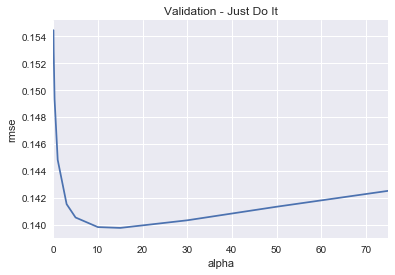

In [48]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [49]:
cv_ridge.min()

0.13976596285220708

## Lasso regression (L1 regularization)

In [50]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

C:\Users\deera\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [51]:
rmse_cv(model_lasso).mean()

C:\Users\deera\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\deera\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\deera\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\deera\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increa

0.13898193727700145

Lasso의 RMSE가 Ridge보다 작음!

In [52]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [53]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 119 variables and eliminated the other 169 variables


In [54]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

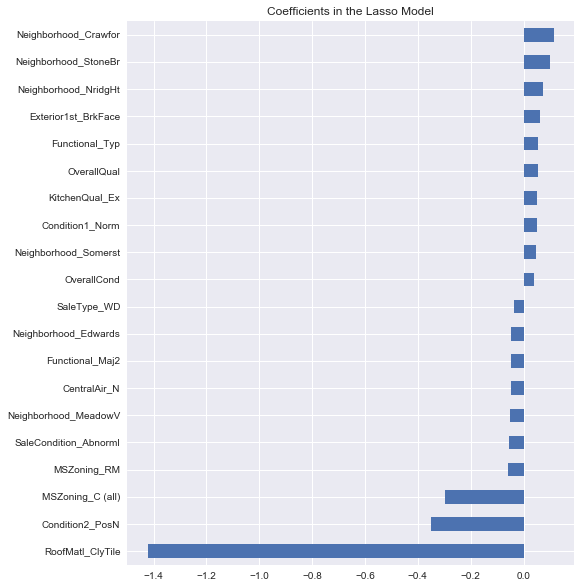

In [55]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

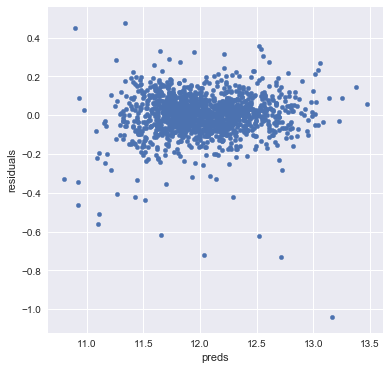

In [56]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

## Adding an xgboost model

In [57]:
# import xgboost as xgb

In [58]:
# dtrain = xgb.DMatrix(X_train, label = y)
# dtest = xgb.DMatrix(X_test)

# params = {"max_depth":2, "eta":0.1}
# model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

In [59]:
lasso_preds = np.expm1(model_lasso.predict(X_test))
# lasso_preds = model_lasso.predict(X_test)

In [60]:
# preds = 0.7*lasso_preds + 0.3*xgb_preds
preds = 1.0*lasso_preds

In [61]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("output.csv", index = False)

## Elastic Net Regression

In [62]:
from mpl_toolkits.mplot3d import Axes3D

alphas = [0.005, 0.01, 0.05, 0.1, 0.3, 1]
l1 = [1, 0.1, 0.001, 0.0005, 0]
assembles = [(a, b) for b in l1 for a in alphas]
cv_elastic = [rmse_cv(ElasticNet(alpha = alpha, l1_ratio=l1)).mean() 
            for alpha, l1 in assembles]

C:\Users\deera\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\deera\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
C:\Users\deera\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\deera\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
C:\Users\deera\Anaconda3\lib\site-packages\s

C:\Users\deera\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\deera\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
C:\Users\deera\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\deera\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
C:\Users\deera\Anaconda3\lib\site-packages\s

In [63]:
inputs = pd.DataFrame(assembles, columns=['alpha', 'l1'])
inputs['rmse'] = cv_elastic
inputs.sort_values('rmse')[:3]

,alpha,l1,rmse
6,0.005,0.1000,0.138666
13,0.010,0.0010,0.139697
19,0.010,0.0005,0.139733


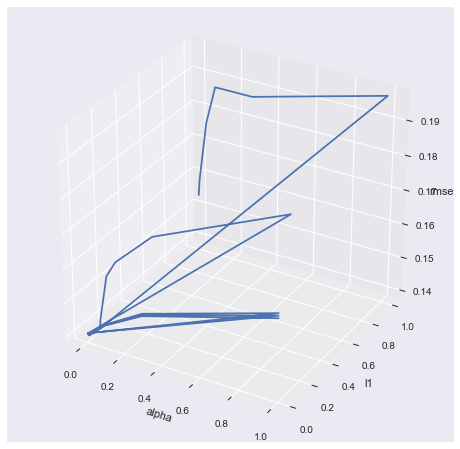

In [64]:
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
threedee = plt.figure().gca(projection='3d')
threedee.plot(inputs['alpha'], inputs['l1'], inputs['rmse'])
threedee.set_xlabel('alpha')
threedee.set_ylabel('l1')
threedee.set_zlabel('rmse')
plt.show()

In [65]:
model_elastic = ElasticNet(alpha = 0.005, l1_ratio = 0.1).fit(X_train, y)

In [66]:
rmse_cv(model_elastic).mean()

0.1386657927635065

In [67]:
elastic_preds = np.expm1(model_elastic.predict(X_test))

In [68]:
elastic_solution = pd.DataFrame({"id":test.Id, "SalePrice":elastic_preds})
elastic_solution.to_csv("elastic_output.csv", index = False)

In [72]:
solution[solution['SalePrice'] == 0]

,SalePrice,id
